In [1]:
from dataclasses import dataclass
import time
import optax
import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from genjax import grasp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
label_fontsize = 70  # Set the desired font size here

In [2]:
@genjax.gen
def top_model(θ):
    x = genjax.tfp_normal(jnp.cos(θ), 0.01) @ "x"
    y = genjax.tfp_normal(jnp.sin(θ), 0.01) @ "y"
    return (x, y)


@genjax.gen
def bottom_model(θ):
    x = genjax.tfp_normal(1 - jnp.cos(θ), 0.01) @ "x"
    y = genjax.tfp_normal((1 - jnp.sin(θ)) - 0.8, 0.01) @ "y"
    return (x, y)

In [3]:
key, sub_key = jax.random.split(key)
theta_range = jnp.arange(0.0, jnp.pi, step=1 / 3600)
sub_keys = jax.random.split(sub_key, len(theta_range))
tr = jax.jit(jax.vmap(top_model.simulate))(sub_keys, (theta_range,))
top_chm = tr.strip()
print(len(theta_range))

11310


In [4]:
key, sub_key = jax.random.split(key)
theta_range = jnp.arange(0.0, jnp.pi, step=1 / 3600)
sub_keys = jax.random.split(sub_key, len(theta_range))
tr = jax.jit(jax.vmap(bottom_model.simulate))(sub_keys, (theta_range,))
bottom_chm = tr.strip()

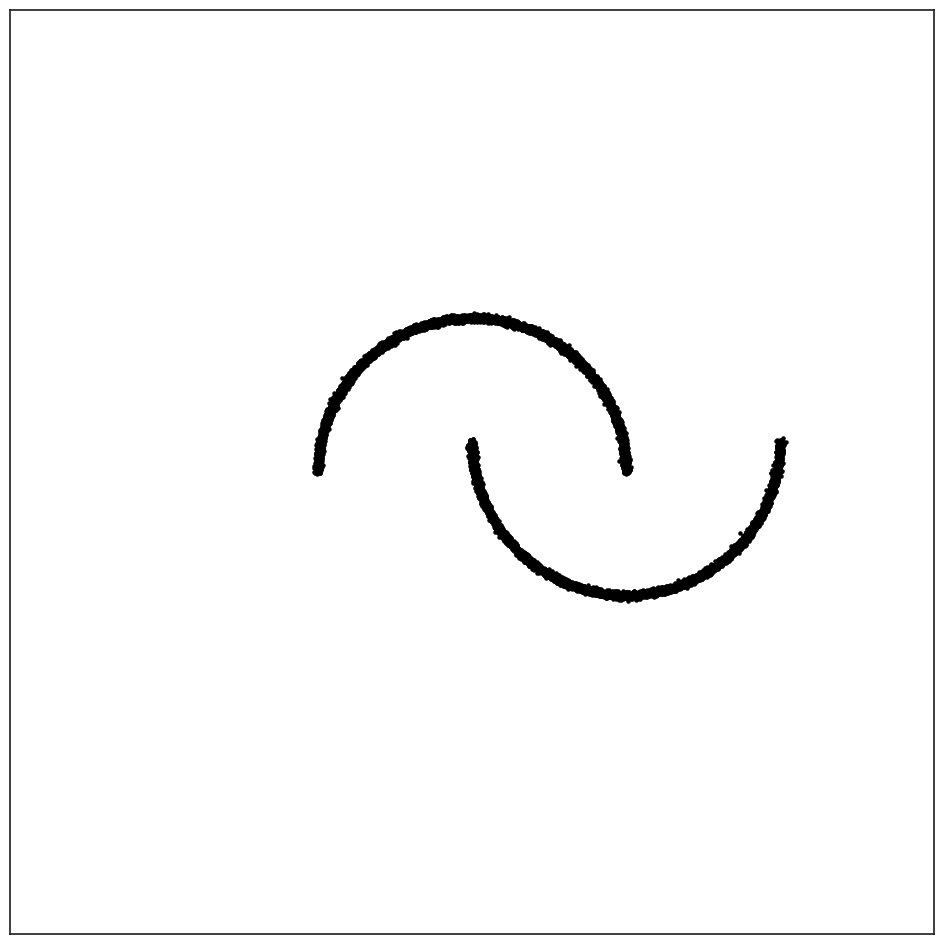

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(top_chm["x"], top_chm["y"], c="black", marker=".", s=20)
ax.scatter(bottom_chm["x"], bottom_chm["y"], c="black", marker=".", s=20)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.show()

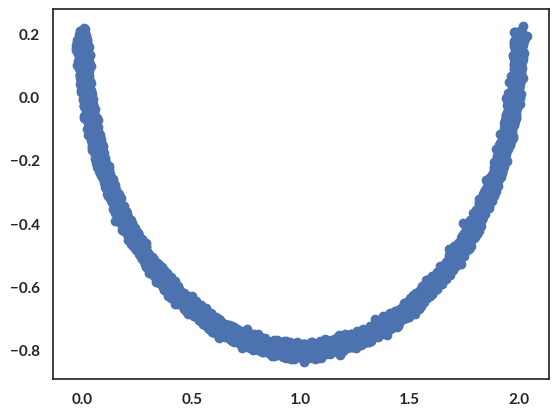

In [6]:
bottom_data = jnp.stack([bottom_chm["x"], bottom_chm["y"]]).transpose()
plt.scatter(bottom_data[:, 0], bottom_data[:, 1])

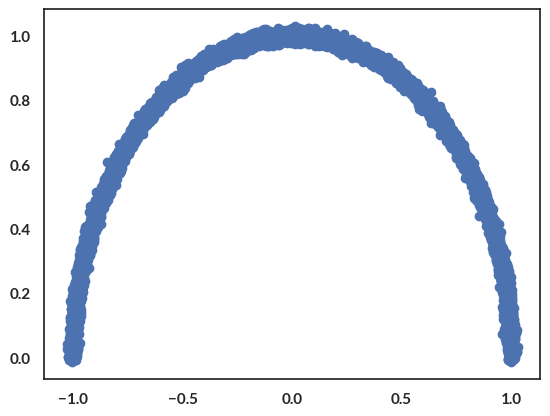

In [7]:
top_data = jnp.stack([top_chm["x"], top_chm["y"]]).transpose()
plt.scatter(top_data[:, 0], top_data[:, 1])

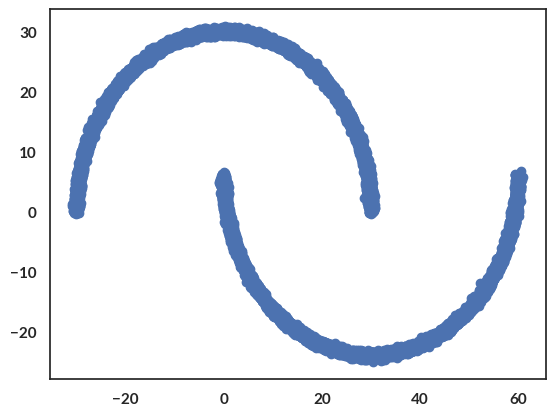

In [8]:
data = jnp.concatenate([30 * top_data, 30 * bottom_data])
plt.scatter(data[:, 0], data[:, 1])

In [9]:
data.shape

(22620, 2)

## Model & guide

In [10]:
###############
# Deep layers #
###############


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(10, 400, key=key1)
        dense_2 = eqx.nn.Linear(400, 4, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, v):
        v = self.dense_1(v)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:2], jax.nn.softplus(v[2:])


# Create decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(2, 400, key=key1)
        dense_2 = eqx.nn.Linear(400, 20, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, v):
        v = self.dense_1(v)
        v = jax.nn.softplus(v)
        v = self.dense_2(v)
        return v[0:10], jax.nn.softplus(v[10:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@genjax.gen
@typecheck
def model(decoder: Decoder):
    latent = grasp.mv_normal_diag_reparam(jnp.zeros(10), jnp.ones(10)) @ "latent"
    obs_mean, obs_sigma_scale = decoder(latent)
    img = grasp.mv_normal_diag_reparam(obs_mean, obs_sigma_scale) @ "image"
    return obs_mean


@genjax.gen
@typecheck
def guide(chm, encoder: Encoder):
    image = chm["image"]
    μ_latent, Σ_latent = encoder(image)
    z = grasp.mv_normal_diag_reparam(μ_latent, Σ_latent) @ "latent"

## Training

In [11]:
def data_loader(
    data,
    batch_size,
    shuffle=False,
):
    N = len(data)
    data_idxs = jnp.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

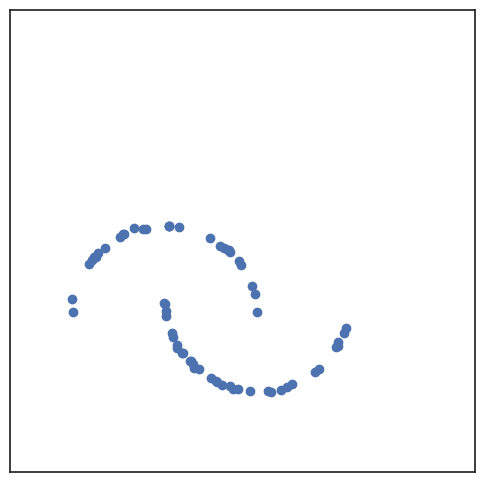

In [12]:
train_init, train_fetch = data_loader(data, 64, shuffle=True)
key, sub_key = jax.random.split(key)
num_batch, train_idx = train_init(sub_key)
batch_data = train_fetch(11, train_idx)
fig, ax = plt.subplots(figsize=(6, 6))

# Set the limits of the plot
ax.scatter(batch_data[:, 0], batch_data[:, 1])
ax.set_xlim(-50, 100)
ax.set_ylim(-50, 100)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.show()

In [13]:
batch_size = 64
learning_rate = 1.0e-4
num_epochs = 200
train_init, train_fetch = data_loader(data, batch_size)


def unsupervised_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def _grads(key, params, data):
            (
                decoder,
                encoder,
            ) = params

            img_data = genjax.choice_map({"image": data})
            objective = grasp.elbo(model, guide, img_data)
            loss, params_grads = objective.value_and_grad_estimate(
                key,
                (
                    (decoder,),
                    (img_data, encoder),
                ),
            )

            (
                (decoder_grads,),
                (_, encoder_grads),
            ) = params_grads
            return loss, (
                decoder_grads,
                encoder_grads,
            )

        sub_keys = jax.random.split(key, len(data_batch))
        loss, params_grads = jax.vmap(_grads, in_axes=(0, None, 0))(
            sub_keys, params, data_batch
        )

        params_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            params_grads,
        )
        updates, opt_state = optimiser.update(params_grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


# Train.
adam = optax.adam(learning_rate)
unsupervised_updater = unsupervised_update(model, guide, adam)
params = (
    decoder,
    encoder,
)


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)
        params, opt_state, loss = unsupervised_updater(
            updater_key, params, opt_state, batch
        )
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
    )
    return params, opt_state, losses


opt_state = adam.init(params)
t0 = time.perf_counter()
losses = []
accuracy = []
for i in range(0, num_epochs + 1):
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)
    key, sub_key = jax.random.split(key)
    params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
    elapsed = time.perf_counter() - t0
    if i % 50 == 0:
        print(f"Epoch={i}, elapsed={elapsed:.2f}, loss={jnp.mean(loss):.2f}")

Epoch=0, elapsed=0.85, loss=-138.30
Epoch=50, elapsed=3.00, loss=-9.35
Epoch=100, elapsed=5.10, loss=-9.44
Epoch=150, elapsed=7.19, loss=-9.52
Epoch=200, elapsed=9.29, loss=-12.81


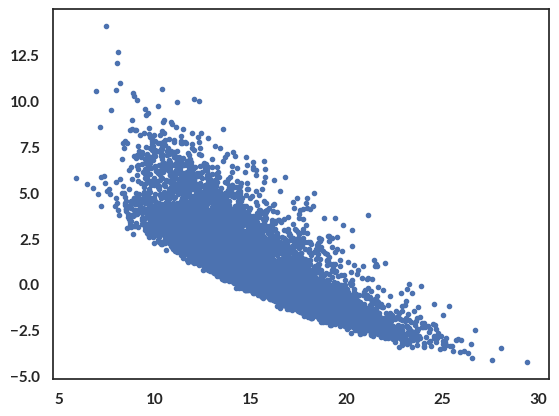

In [14]:
trained_decoder, *_ = params
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(key, 10000)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, (trained_decoder,))
v = tr.get_retval()
x = v[:, 0]
y = v[:, 1]
plt.scatter(x, y, marker=".")

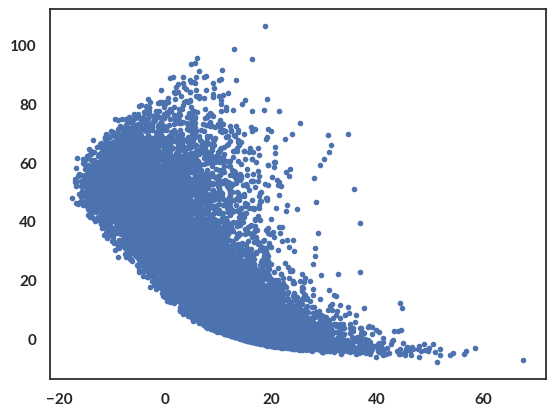

In [15]:
trained_decoder, trained_encoder = params
key, sub_key = jax.random.split(key)
data_chm = genjax.choice_map({"image": data})
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, len(data))
tr = jax.jit(jax.vmap(guide.simulate, in_axes=(0, (0, None))))(
    sub_keys, (data_chm, trained_encoder)
)
v, _ = jax.vmap(trained_decoder)(tr["latent"])
x = v[:, 0]
y = v[:, 1]
plt.scatter(x, y, marker=".")